# Your First AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) from Oxford of 102 flower categories, you can see a few examples below.

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load the image dataset and create a pipeline.
* Build and Train an image classifier on this dataset.
* Use your trained model to perform inference on flower images.

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

## Import Resources

In [1]:
!pip install keras-cv
# !pip install tensorflow
# !pip install tensorflow_datasets
# !pip install tensorflow_hub
# !pip install tf_keras

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# TODO: Make all necessary imports.

# TensorFlow and Keras imports
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub
import tf_keras
from tf_keras.models import load_model
from keras_cv import layers

# General imports
import json
import numpy as np
import matplotlib.pyplot as plt

2025-04-07 18:44:56.280797: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 18:44:56.280862: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 18:44:56.280933: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Using TensorFlow backend


In [4]:
tfds.disable_progress_bar()
tf.keras.backend.clear_session()

In [5]:
import keras_cv
print(keras_cv.__version__)

0.9.0


In [6]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

## Load the Dataset

Here you'll use `tensorflow_datasets` to load the [Oxford Flowers 102 dataset](https://www.tensorflow.org/datasets/catalog/oxford_flowers102). This dataset has 3 splits: `'train'`, `'test'`, and `'validation'`.  You'll also need to make sure the training data is normalized and resized to 224x224 pixels as required by the pre-trained networks.

The validation and testing sets are used to measure the model's performance on data it hasn't seen yet, but you'll still need to normalize and resize the images to the appropriate size.

In [7]:
# TODO: Load the dataset with TensorFlow Datasets.
flowers, metadata = tfds.load('oxford_flowers102', as_supervised=True, with_info=True)
# TODO: Create a training set, a validation set and a test set.
training_set, test_set, validation_set = flowers['train'], flowers['test'], flowers['validation']

## Explore the Dataset

In [8]:
# TODO: Get the number of examples in each set from the dataset info.
num_training_examples = metadata.splits['train'].num_examples
num_test_examples = metadata.splits['test'].num_examples
num_validation_test = metadata.splits['validation'].num_examples

# TODO: Get the number of classes in the dataset from the dataset info.
num_classes = metadata.features['label'].num_classes

In [9]:
# Print dataset information
print(f"Number of training examples: {num_training_examples}")
print(f"Number of test examples: {num_test_examples}")
print(f"Number of validation examples: {num_validation_test}")
print(f"Number of classes: {num_classes}")

Number of training examples: 1020
Number of test examples: 6149
Number of validation examples: 1020
Number of classes: 102


In [10]:
# TODO: Print the shape and corresponding label of 3 images in the training set.
for image, label in training_set.take(3):
    print(f"Image shape: {image.shape}")
    print(f"Label: {label.numpy()}\n")

Image shape: (500, 667, 3)
Label: 72

Image shape: (500, 666, 3)
Label: 84

Image shape: (670, 500, 3)
Label: 70



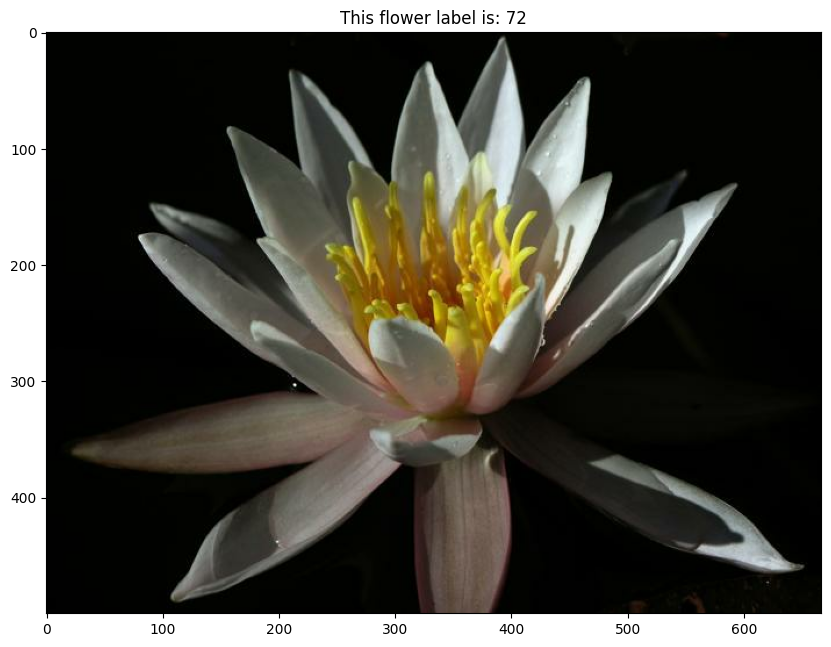

In [11]:
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding image label.
for img, label in training_set.take(1):
    img = img.numpy()
    label = label.numpy()

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title(f'This flower label is: {label}')
plt.show()

### Label Mapping

You'll also need to load in a mapping from label to category name. You can find this in the file `label_map.json`. It's a JSON object which you can read in with the [`json` module](https://docs.python.org/3.7/library/json.html). This will give you a dictionary mapping the integer coded labels to the actual names of the flowers.

In [12]:
with open('label_map.json', 'r') as f:
    class_names = json.load(f)

In [13]:
class_names['72']

'water lily'

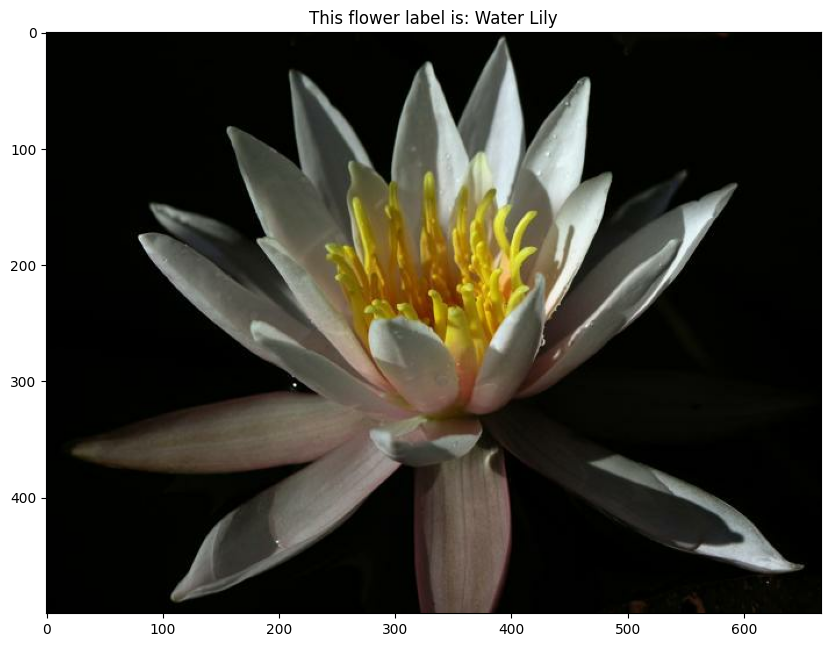

In [14]:
# TODO: Plot 1 image from the training set. Set the title
# of the plot to the corresponding class name.

for img, label in training_set.take(1):
    img = img.numpy()
    label = label.numpy()
    label = str(label)
plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.title(f'This flower label is: {class_names[label].title()}')
plt.show()

## Create Pipeline

In [15]:
# TODO: Create a pipeline for each set.

# Preprocessing functions for image classification pipeline

def normalize(image, label, IMG_RES):
    """
    Normalize image pixel values to the range [0, 1] and resize the image to a target size.

    Parameters:
    - image: A tensor representing an image with pixel values [0, 255].
    - label: The corresponding label of the image.
    - IMG_RES: An integer specifying the target size to resize the image (both height and width).
              The image will be resized to (IMG_RES, IMG_RES).

    Returns:
    - image: The image tensor scaled to [0.0, 1.0] and resized to the target size (IMG_RES, IMG_RES).
    - label: The unchanged label.
    """
    # Resize the image to the target size (IMG_RES, IMG_RES)
    image = tf.image.resize(image, (IMG_RES, IMG_RES))

    # Normalize the image by casting it to float32 and scaling pixel values to [0.0, 1.0]
    image = tf.cast(image, tf.float32) / 255.0

    return image, label

In [16]:
flip = layers.RandomFlip("horizontal")
rotation = layers.RandomRotation(0.2)
zoom = layers.RandomZoom(0.3)

def augment_combined(image, label):
    """
    Applies both separate and sequential data augmentation techniques to a single image.

    The function generates five versions of the input image:
    1. Original image (no augmentation)
    2. Flipped image (random horizontal flip)
    3. Rotated image (random rotation ±20%)
    4. Zoomed image (random zoom up to 30%)
    5. Sequentially augmented image (flip → rotate → zoom)

    This combined approach increases the diversity of training samples and improves model generalization.

    Parameters:
    ----------
    image : tf.Tensor
        A single image tensor of shape (H, W, C). Should be dtype uint8 or float32.
    label : tf.Tensor or int
        The label corresponding to the input image.

    Returns:
    -------
    images : tf.Tensor
        A tensor of shape (5, H, W, C), containing:
            - The original image
            - Three separately augmented images
            - One sequentially augmented image
    labels : tf.Tensor
        A tensor of shape (5,) with the same label repeated for each image variant.
    """
    original = tf.cast(image, tf.float32)

    # Separate augmentations
    flipped = flip(original)
    rotated = rotation(original)
    zoomed = zoom(original)

    # Sequential augmentation
    sequential = flip(original)
    sequential = rotation(sequential)
    sequential = zoom(sequential)

    # Combine all versions
    images = tf.stack([original, flipped, rotated, zoomed, sequential], axis=0)
    labels = tf.repeat(label, repeats=5)

    return images, labels

def flat_map_augmented_dataset(image, label):
    images, labels = augment_combined(image, label)
    return tf.data.Dataset.from_tensor_slices((images, labels))

In [17]:
# Constants
BATCH_SIZE = 32
IMG_RES = 224

# Step 1: Preprocess the training set
train_processed_set = training_set.map(
    lambda image, label: normalize(image, label, IMG_RES),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_processed_set = train_processed_set.flat_map(flat_map_augmented_dataset)
train_processed_set = train_processed_set.shuffle(1000)

# Step 2: Preprocess the validation set
validation_processed_set = (
    validation_set
    .map(lambda image, label: normalize(image, label, IMG_RES), num_parallel_calls=tf.data.AUTOTUNE)
)

# Step 3: Preprocess the test set
test_processed_set = (
    test_set
    .map(lambda image, label: normalize(image, label, IMG_RES), num_parallel_calls=tf.data.AUTOTUNE)
)

# Step 4: Batch and prefetch the datasets for faster training

train_batch_set = (
    train_processed_set
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

val_batch_set = (
    validation_processed_set
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_batch_set = (
    test_processed_set
    .batch(BATCH_SIZE)
   .prefetch(tf.data.AUTOTUNE)
)

# Build and Train the Classifier

Now that the data is ready, it's time to build and train the classifier. You should use the MobileNet pre-trained model from TensorFlow Hub to get the image features. Build and train a new feed-forward classifier using those features.

We're going to leave this part up to you. If you want to talk through it with someone, chat with your fellow students!

Refer to the rubric for guidance on successfully completing this section. Things you'll need to do:

* Load the MobileNet pre-trained network from TensorFlow Hub.
* Define a new, untrained feed-forward network as a classifier.
* Train the classifier.
* Plot the loss and accuracy values achieved during training for the training and validation set.
* Save your trained model as a Keras model.

We've left a cell open for you below, but use as many as you need. Our advice is to break the problem up into smaller parts you can run separately. Check that each part is doing what you expect, then move on to the next. You'll likely find that as you work through each part, you'll need to go back and modify your previous code. This is totally normal!

When training make sure you're updating only the weights of the feed-forward network. You should be able to get the validation accuracy above 70% if you build everything right.

**Note for Workspace users:** One important tip if you're using the workspace to run your code: To avoid having your workspace disconnect during the long-running tasks in this notebook, please read in the earlier page in this lesson called Intro to GPU Workspaces about Keeping Your Session Active. You'll want to include code from the workspace_utils.py module. Also, If your model is over 1 GB when saved as a checkpoint, there might be issues with saving backups in your workspace. If your saved checkpoint is larger than 1 GB (you can open a terminal and check with `ls -lh`), you should reduce the size of your hidden layers and train again.

In [18]:
# Define the input image shape
IMAGE_SHAPE = (224, 224)

# Define the MobileNetV2 feature extractor from TensorFlow Hub
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

# Build the model architecture
model = tf.keras.Sequential(name='Oxford102_FlowerNet',
    layers = [
        hub.KerasLayer(mobilenet_v2, input_shape=IMAGE_SHAPE+(3,), trainable=False, name="mobilenet_feature_extractor"),
        tf.keras.layers.Dropout(0.2, name="dropout_layer"),  # Adding a Dropout layer with a rate of 50%

        tf.keras.layers.Dense(102, activation='softmax', name="output_dense_layer")
    ]
)

# Build the model by passing a dummy input to the model
model.build((None, *IMAGE_SHAPE, 3))

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "Oxford102_FlowerNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_feature_extracto  (None, 1280)              2257984   
 r (KerasLayer)                                                  
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 output_dense_layer (Dense)  (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [19]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',     # Monitor validation loss
    patience=3,            # Number of epochs with no improvement after which training will stop
    min_delta=0.001,       # Minimum change to qualify as improvement
    mode='min',            # Stop when the quantity monitored stops decreasing
    restore_best_weights=True,  # Restore model weights from the epoch with the best value
    verbose=1              # Print messages when stopping
)
]

EPOCHS = 10
with tf.device('/GPU:0'):
    history = model.fit(train_batch_set, validation_data=val_batch_set, epochs=EPOCHS, callbacks=callbacks)

Epoch 1/10
160/160 [==============================] - 57s 263ms/step - loss: 4.5034 - accuracy: 0.0463 - val_loss: 3.9434 - val_accuracy: 0.1422
Epoch 2/10
160/160 [==============================] - 47s 244ms/step - loss: 3.4934 - accuracy: 0.2304 - val_loss: 3.2262 - val_accuracy: 0.3598
Epoch 3/10
160/160 [==============================] - 43s 224ms/step - loss: 2.7747 - accuracy: 0.4508 - val_loss: 2.6798 - val_accuracy: 0.5069
Epoch 4/10
160/160 [==============================] - 43s 222ms/step - loss: 2.2148 - accuracy: 0.6122 - val_loss: 2.2794 - val_accuracy: 0.6137
Epoch 5/10
160/160 [==============================] - 43s 223ms/step - loss: 1.7997 - accuracy: 0.7149 - val_loss: 1.9830 - val_accuracy: 0.6637
Epoch 6/10
160/160 [==============================] - 43s 222ms/step - loss: 1.4909 - accuracy: 0.7880 - val_loss: 1.7617 - val_accuracy: 0.7029
Epoch 7/10
160/160 [==============================] - 43s 221ms/step - loss: 1.2794 - accuracy: 0.8151 - val_loss: 1.5930 - val_ac

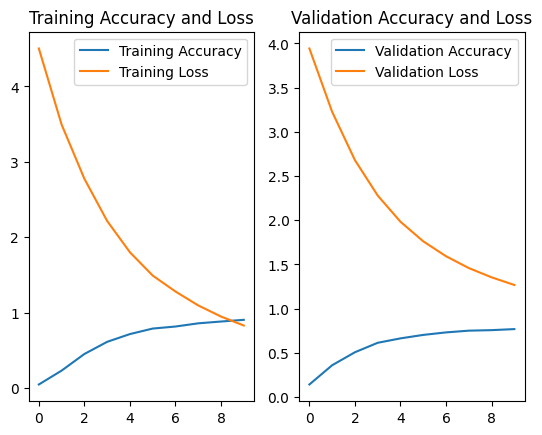

In [20]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs_range = range(len(train_acc))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_acc, label='Training Accuracy')
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training Accuracy and Loss')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Validation Accuracy and Loss')

plt.show()


## Testing your Network

It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. You should be able to reach around 70% accuracy on the test set if the model has been trained well.

In [21]:
# TODO: Print the loss and accuracy values achieved on the entire test set.
test_loss, test_accuracy = model.evaluate(test_batch_set)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

193/193 [==============================] - 23s 116ms/step - loss: 1.3665 - accuracy: 0.7417
Test Loss: 1.36649489402771
Test Accuracy: 0.7417466044425964


## Save the Model

Now that your network is trained, save the model so you can load it later for making inference. In the cell below save your model as a Keras model (*i.e.* save it as an HDF5 file).

In [22]:
# TODO: Save your trained model as a Keras model.
model_name = 'Oxford102_FlowerNet'
model_file_path = f'./{model_name}.h5'

# Save the trained model as a Keras model (HDF5 file)
model.save(model_file_path)

## Load the Keras Model

Load the Keras model you saved above.

In [23]:
# Define custom_objects to pass the KerasLayer for TensorFlow Hub
custom_objects = {'KerasLayer': hub.KerasLayer}

# Load the model using the correct custom_objects argument
model_file_path = './Oxford102_FlowerNet.h5'
loaded_model = load_model(model_file_path, custom_objects=custom_objects)

# Print the model summary to confirm it has been loaded correctly
loaded_model.summary()


Model: "Oxford102_FlowerNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 module_wrapper (ModuleWrap  (None, 1280)              2257984   
 per)                                                            
                                                                 
 dropout_layer (Dropout)     (None, 1280)              0         
                                                                 
 output_dense_layer (Dense)  (None, 102)               130662    
                                                                 
Total params: 2388646 (9.11 MB)
Trainable params: 130662 (510.40 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Inference for Classification

Now you'll write a function that uses your trained network for inference. Write a function called `predict` that takes an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

The `predict` function will also need to handle pre-processing the input image such that it can be used by your model. We recommend you write a separate function called `process_image` that performs the pre-processing. You can then call the `process_image` function from the `predict` function.

### Image Pre-processing

The `process_image` function should take in an image (in the form of a NumPy array) and return an image in the form of a NumPy array with shape `(224, 224, 3)`.

First, you should convert your image into a TensorFlow Tensor and then resize it to the appropriate size using `tf.image.resize`.

Second, the pixel values of the input images are typically encoded as integers in the range 0-255, but the model expects the pixel values to be floats in the range 0-1. Therefore, you'll also need to normalize the pixel values.

Finally, convert your image back to a NumPy array using the `.numpy()` method.

In [24]:
# TODO: Create the process_image function

def process_image(image, image_size=224):
    """
    Preprocesses an input image for use in a machine learning model.

    This function performs the following steps:
        1. Converts the input image to a float32 TensorFlow tensor.
        2. Resizes the image to the specified dimensions (image_size x image_size).
        3. Normalizes pixel values to the range [0, 1].
        4. Converts the image to a NumPy array and removes singleton dimensions.

    Args:
        image (Tensor or array-like): The input image to preprocess.
                                      Expected shape: (height, width, channels).
        image_size (int): The target size to resize the image's height and width.

    Returns:
        np.ndarray: The preprocessed image as a NumPy array with pixel values in [0, 1]
                    and shape (image_size, image_size, channels), or (image_size, image_size)
                    if it's a grayscale image.
    """
    # Convert the image to a TensorFlow tensor with float32 data type
    image = tf.cast(image, tf.float32)

    # Resize the image to the target size (image_size, image_size)
    image = tf.image.resize(image, [image_size, image_size])

    # Normalize the image by scaling pixel values to [0, 1]
    image /= 255.0

    # Convert the image back to a NumPy array and remove any singleton dimensions
    image = image.numpy().squeeze()

    return image


To check your `process_image` function we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

The code below loads one of the above images using `PIL` and plots the original image alongside the image produced by your `process_image` function. If your `process_image` function works, the plotted image should be the correct size.

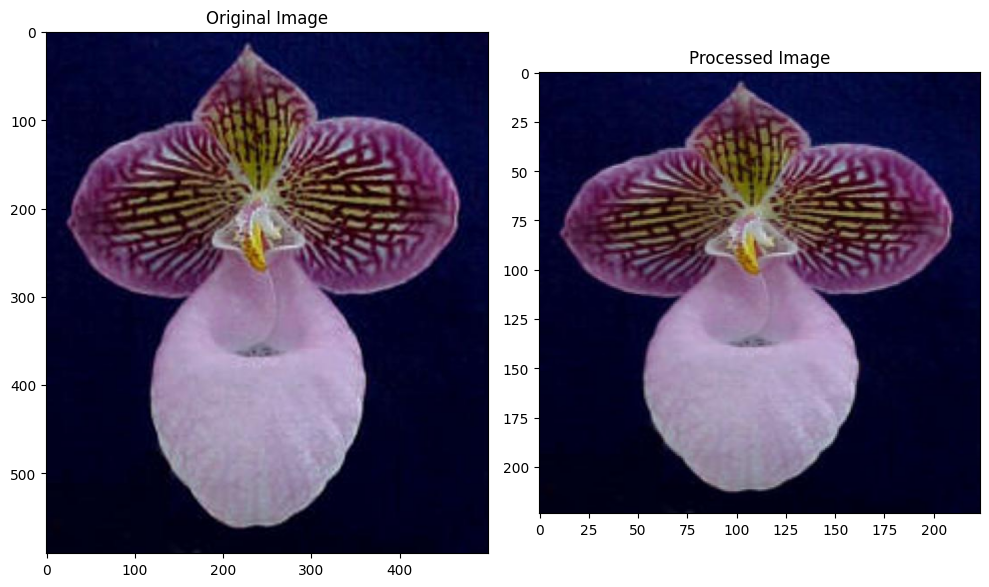

In [25]:
from PIL import Image

image_path = './test_images/hard-leaved_pocket_orchid.jpg'
im = Image.open(image_path)
test_image = np.asarray(im)

processed_test_image = process_image(test_image)

fig, (ax1, ax2) = plt.subplots(figsize=(10,10), ncols=2)
ax1.imshow(test_image)
ax1.set_title('Original Image')
ax2.imshow(processed_test_image)
ax2.set_title('Processed Image')
plt.tight_layout()
plt.show()

Once you can get images in the correct format, it's time to write the `predict` function for making inference with your model.

### Inference

Remember, the `predict` function should take an image, a model, and then returns the top $K$ most likely class labels along with the probabilities. The function call should look like:

```python
probs, classes = predict(image_path, model, top_k)
```

If `top_k=5` the output of the `predict` function should be something like this:

```python
probs, classes = predict(image_path, model, 5)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

Your `predict` function should use `PIL` to load the image from the given `image_path`. You can use the [Image.open](https://pillow.readthedocs.io/en/latest/reference/Image.html#PIL.Image.open) function to load the images. The `Image.open()` function returns an `Image` object. You can convert this `Image` object to a NumPy array by using the `np.asarray()` function.

**Note:** The image returned by the `process_image` function is a NumPy array with shape `(224, 224, 3)` but the model expects the input images to be of shape `(1, 224, 224, 3)`. This extra dimension represents the batch size. We suggest you use the `np.expand_dims()` function to add the extra dimension.

In [26]:
# TODO: Create the predict function
def predict(image_path, model, top_k=5):
    """
    Classifies a single image, returns the top-k predicted classes and their indices, 
    and prints the top-k predictions.

    Parameters:
    - image_path: Path to the image file
    - model: Trained model to make predictions
    - top_k: Number of top predictions to return (default is 5)

    Returns:
    - probs: List of top-k probabilities
    - classes: List of top-k class names
    """
    # Open the image using PIL
    img = Image.open(image_path)

    # Process the image using the process_image function
    img_array = np.array(img)
    processed_image = process_image(img_array, image_size=224)

    # Add batch dimension to the processed image
    img_array_expanded = np.expand_dims(processed_image, axis=0)

    # Get predictions from the model
    predictions = model.predict(img_array_expanded)

    # Get the top-k predicted indices and probabilities
    top_k_indices = np.argsort(predictions[0])[-top_k:][::-1]
    top_k_probs = predictions[0][top_k_indices]

    # Map the indices to class names (assuming class_names is available)
    top_classes = [class_names[str(idx)] for idx in top_k_indices]

    return top_k_probs, top_classes

# Sanity Check

It's always good to check the predictions made by your model to make sure they are correct. To check your predictions we have provided 4 images in the `./test_images/` folder:

* cautleya_spicata.jpg
* hard-leaved_pocket_orchid.jpg
* orange_dahlia.jpg
* wild_pansy.jpg

In the cell below use `matplotlib` to plot the input image alongside the probabilities for the top 5 classes predicted by your model. Plot the probabilities as a bar graph. The plot should look like this:

<img src='assets/inference_example.png' width=600px>

You can convert from the class integer labels to actual flower names using `class_names`.

1/1 [==============================] - 0s 26ms/step


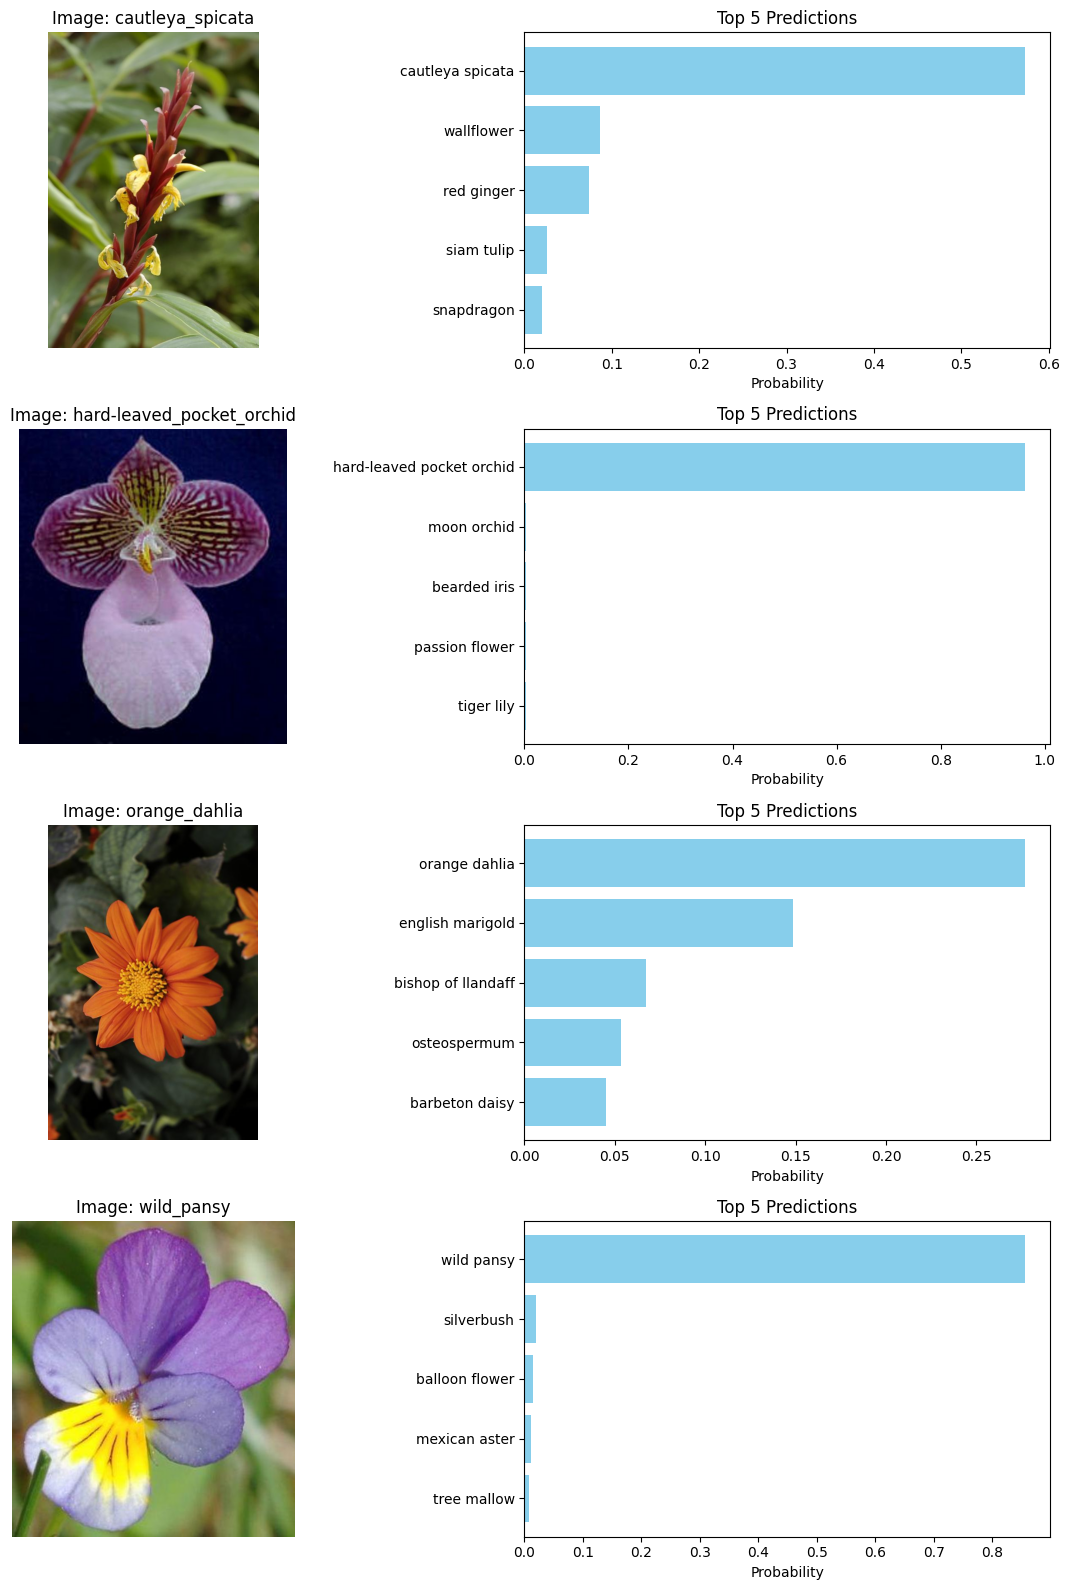

In [27]:
# TODO: Plot the input image along with the top 5 classes

def display_predictions(image_names, num_images, model, class_names, top_k=5):
    """
    Displays a set of images with their top-K class predictions and probabilities.

    Parameters:
    - image_names: List of image file names (e.g., ['img1.jpg', 'img2.jpg'])
    - num_images: Number of images to display (should be <= len(image_names))
    - model: Trained model for prediction
    - class_names: Dictionary mapping class indices to names
    - top_k: Number of top classes to show in the bar chart
    """
    assert num_images <= len(image_names), "num_images cannot be more than the list length"

    plt.figure(figsize=(12, num_images * 4))

    for i in range(num_images):
        image_name = image_names[i]
        image_path = f'./test_images/{image_name}'

        # Run prediction
        probs, classes = predict(image_path, model, top_k)

        # Load image for display
        img = Image.open(image_path)

        # Image subplot
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(img)
        plt.title(f"Image: {image_name.split('.')[0]}")
        plt.axis('off')

        # Bar chart subplot
        plt.subplot(num_images, 2, 2*i + 2)
        y_pos = np.arange(len(classes))
        plt.barh(y_pos, probs, color='skyblue')
        plt.yticks(y_pos, classes)
        plt.xlabel("Probability")
        plt.gca().invert_yaxis()  # highest probability at top
        plt.title(f"Top {top_k} Predictions")

    plt.tight_layout()
    plt.show()

images = ['cautleya_spicata.jpg', 'hard-leaved_pocket_orchid.jpg', 'orange_dahlia.jpg',
                    'wild_pansy.jpg']

display_predictions(images, num_images=4, model=loaded_model, class_names=class_names, top_k=5)



In [32]:
!python predict.py ./test_images/cautleya_spicata.jpg Oxford102_FlowerNet.h5 --top_k 3 --category_names label_map.json


2025-04-07 19:21:49.942569: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-07 19:21:49.942628: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-07 19:21:49.942668: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
1/1 [==============================] - 7s 7s/step
Top predictions:
cautleya spicata: 0.5731
wallflower: 0.0863
red ginger: 0.0741


In [44]:
!jupyter nbconvert Project_Image_Classifier_Project.ipynb --to html

[NbConvertApp] Converting notebook Project_Image_Classifier_Project.ipynb to html
[NbConvertApp] Writing 2868982 bytes to Project_Image_Classifier_Project.html
